# Imports


In [1]:
# cell 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import cholesky, solve_triangular
from scipy.special import kv, gamma
import seaborn as sns
import pyproj



# Load data

In [2]:
#cell 2

# Load dataset
csv_file = "C:\ASU\Semester 2\space robotics and ai\codeyy\GP\Data\dec6.csv"
data = pd.read_csv(csv_file)
print(f"Loaded {len(data)} data points from: {csv_file}")

# Display dataset info
print("First few rows of raw data:")
print(data.head())
print(f"Raw Latitude range: {data['Latitude'].min()} to {data['Latitude'].max()}")
print(f"Raw Longitude range: {data['Longitude'].min()} to {data['Longitude'].max()}")



Loaded 3989 data points from: C:\ASU\Semester 2\space robotics and ai\codeyy\GP\Data\dec6.csv
First few rows of raw data:
     Time (UTC)   Latitude   Longitude  Depth (Sonar)  Temperature (°C)    pH  \
0  1.733528e+09  33.430408 -111.928888          1.551             16.72  9.04   
1  1.733528e+09  33.430408 -111.928888          1.778             16.73  9.04   
2  1.733528e+09  33.430408 -111.928888          2.031             16.73  9.04   
3  1.733528e+09  33.430408 -111.928889          2.274             16.73  9.04   
4  1.733528e+09  33.430408 -111.928888          2.604             16.73  9.04   

   Depth (m)  Conductivity (uS/cm)  Dissolved Oxygen Saturation  \
0       0.02                  1553                        127.8   
1       0.02                  1553                        127.8   
2       0.02                  1552                        127.8   
3       0.02                  1552                        127.8   
4       0.02                  1552                      

<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
C:\Users\battu\AppData\Local\Temp\ipykernel_27472\2848719260.py:4: SyntaxWarning: invalid escape sequence '\A'
  csv_file = "C:\ASU\Semester 2\space robotics and ai\codeyy\GP\Data\dec6.csv"



# Latitude/Longitude coordinates 

    (WGS84) are converted to UTM (meters) using the EPSG:32612 projection for accurate spatial mapping. 
    The `pyproj.Transformer` function applies the transformation, generating X, Y coordinates in meters. 
    A sample of the transformed data and coordinate ranges is printed for verification.


In [3]:
#cell 3

# Define coordinate reference systems (CRS)
utm_crs = pyproj.CRS("EPSG:32612")  # UTM Zone 12N for Tempe, Arizona
wgs84_crs = pyproj.CRS("EPSG:4326")  # WGS84 Latitude/Longitude

# Define transformation from WGS84 (lat/lon) to UTM (X, Y in meters)
transformer = pyproj.Transformer.from_crs(wgs84_crs, utm_crs, always_xy=True)

# Apply transformation to convert Longitude/Latitude to UTM (X, Y)
data["X_coord"], data["Y_coord"] = transformer.transform(
    data["Longitude"].values,  # Input longitude (degrees)
    data["Latitude"].values    # Input latitude (degrees)
)

# Print a sample of the transformed data
print("Sample processed data (in meters):")
print(data[["Latitude", "Longitude", "X_coord", "Y_coord"]].head())

# Print coordinate ranges after conversion
print(f"X_coord range (meters): {data['X_coord'].min()} to {data['X_coord'].max()}")
print(f"Y_coord range (meters): {data['Y_coord'].min()} to {data['Y_coord'].max()}")


Sample processed data (in meters):
    Latitude   Longitude        X_coord       Y_coord
0  33.430408 -111.928888  413649.406157  3.699389e+06
1  33.430408 -111.928888  413649.368872  3.699389e+06
2  33.430408 -111.928888  413649.378070  3.699389e+06
3  33.430408 -111.928889  413649.350180  3.699389e+06
4  33.430408 -111.928888  413649.368278  3.699389e+06
X_coord range (meters): 413595.4251371465 to 413701.0693493731
Y_coord range (meters): 3699388.488145916 to 3699507.1967617515


In [4]:
# cell 4

# Downsample dataset to a maximum of 2000 points for efficiency
max_points_per_file = 1000000000
n = len(data)  # Total number of data points

# Randomly select up to `max_points_per_file` data points (ensuring reproducibility with random_state=42)
sampled_indices = data.sample(min(n, max_points_per_file), random_state=42).index
sampled_indices = sorted(sampled_indices)  # Sorting ensures consistency in data ordering

# Extract the target variable (Surface Temperature in °C)
target_var = "Temperature (°C)"
y = data[target_var].values  # Temperature values

# Extract spatial features (Y_coord, X_coord) for training
X_features = data[["X_coord", "Y_coord"]].values

# Select only the downsampled data points
X_train = X_features[sampled_indices]
y_train = y[sampled_indices]

# Print dataset details after downsampling
print(f"Total data points: {len(data)}, Training subset size: {X_train.shape[0]}")
print("Example training point (2D):", X_train[0])


Total data points: 3989, Training subset size: 3989
Example training point (2D): [ 413649.40615693 3699389.33659766]


In [5]:
# cell 5

# Set Gaussian Process (GP) hyperparameters

# Matérn smoothness parameter:
#   nu = 0.5  -> Exponential kernel (non-differentiable paths)
#   nu = 1.5  -> Once-differentiable paths
#   nu = 2.5  -> Twice-differentiable paths (chosen here)
#   nu → ∞    -> Equivalent to the RBF (Squared Exponential) kernel


nu = 0.5

# Signal standard deviation (sigma_f): Captures the variance of the data 
# We use the standard deviation of the training targets as a rough estimate
sigma_f = np.std(y_train)  

# Noise standard deviation (sigma_n): Accounts for observation noise
# This should be set lower if sensor measurements are very precise
sigma_n = 0.1  

# Base length scale in meters: Defines the characteristic spatial scale for the kernel
base_lengthscale_space = 5  

# Print hyperparameter values
print("\nHyperparameters:")
print(f"nu = {nu}, sigma_f = {sigma_f:.2f}, sigma_n = {sigma_n}")
print(f"base_lengthscale_space = {base_lengthscale_space} meters")

# For nonstationary kernels, allow length scales to vary across space
# We define a modulation factor (alpha) that adjusts the local length scales
alpha = 0.5  # Adjust as needed

# Compute statistical properties of training data coordinates
# mean_x, mean_y -> Mean spatial positions
mean_x = np.mean(X_train[:, 0])  
mean_y = np.mean(X_train[:, 1])  

# range_x, range_y -> Spatial range (max - min) for each coordinate
range_x = np.ptp(X_train[:, 0])  
range_y = np.ptp(X_train[:, 1])  



Hyperparameters:
nu = 0.5, sigma_f = 0.06, sigma_n = 0.1
base_lengthscale_space = 5 meters


In [6]:
# cell 6

def Sigma_matrix(x):
    """
    Computes the local 2x2 covariance matrix for a given location x = [x_coord, y_coord].
    This matrix is nonstationary because the length scales vary with x.
    """
    sigma_x = base_lengthscale_space * (1 + alpha * (x[0] - mean_x) / range_x)
    sigma_y = base_lengthscale_space * (1 + alpha * (x[1] - mean_y) / range_y)
    # Set an off-diagonal term (here using a fixed correlation, e.g., 0.2)
    rho = 0.2
    return np.array([
        [sigma_x**2,       rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2]
    ])



In [7]:
# cell 7

def matern_covariance(x, x_prime, nu=nu, sigma_f=sigma_f):
    """
    Computes the nonstationary Matérn covariance between 2D points x and x_prime.
    """
    Σ_i = Sigma_matrix(x)
    Σ_j = Sigma_matrix(x_prime)
    det_Si = np.linalg.det(Σ_i)
    det_Sj = np.linalg.det(Σ_j)
    det_half = np.linalg.det((Σ_i + Σ_j) / 2.0)
    diff = np.array(x) - np.array(x_prime)
    M = (Σ_i + Σ_j) / 2.0

    try:
        v = np.linalg.solve(M, diff)
        Q_ij = float(diff.dot(v))
    except np.linalg.LinAlgError:
        v = np.linalg.pinv(M).dot(diff)
        Q_ij = float(diff.dot(v))
        
    if Q_ij < 1e-12:
        return sigma_f**2

    prefactor = (det_Si**0.25) * (det_Sj**0.25) / (det_half**0.5)
    arg = np.sqrt(2 * nu * Q_ij)
    matern_part = (arg**nu) * kv(nu, arg)
    norm_const = 1.0 / (gamma(nu) * 2**(nu - 1))
    
    return sigma_f**2 * prefactor * norm_const * matern_part

print("\nNonstationary Matérn kernel (2D) defined.")




Nonstationary Matérn kernel (2D) defined.


In [8]:
# cell 8

# Compute kernel matrix for training data
N = X_train.shape[0]
K = np.zeros((N, N))
for i in range(N):
    for j in range(i, N):
        cov_ij = matern_covariance(X_train[i], X_train[j])
        K[i, j] = cov_ij
        K[j, i] = cov_ij
K += (sigma_n**2) * np.eye(N)

# GP regression: Cholesky decomposition and solve for weights
L = cholesky(K, lower=True)
alpha_weights = solve_triangular(L.T, solve_triangular(L, y_train, lower=True), lower=False)




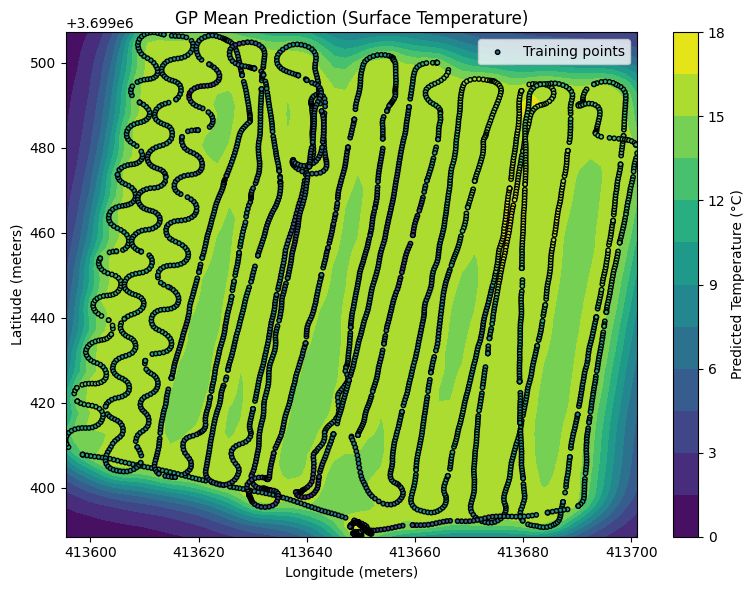

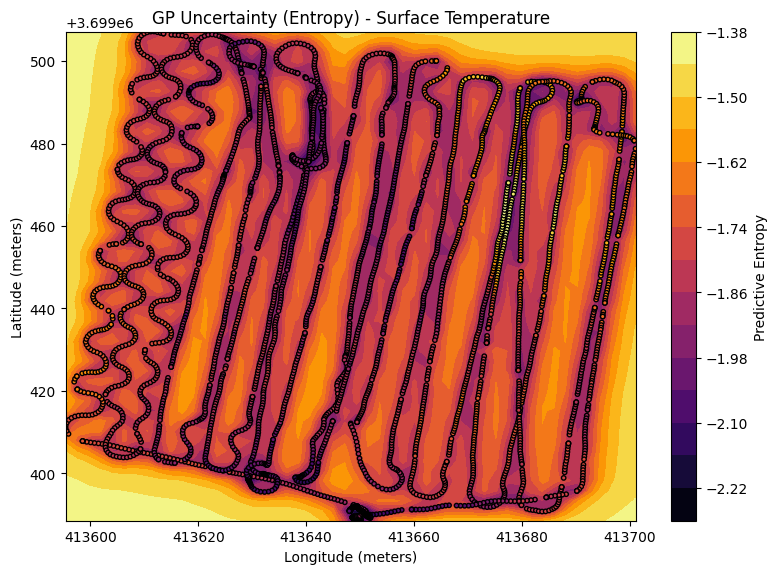

In [9]:
# cell 9

# Generate test grid over the UTM X-Y plane
grid_x = np.linspace(data["X_coord"].min(), data["X_coord"].max(), 50)  # Longitude (X-axis)
grid_y = np.linspace(data["Y_coord"].min(), data["Y_coord"].max(), 50)  # Latitude (Y-axis)

# Ensure the test points are structured as (X, Y) pairs (not (y, x))
X_test = np.array([[x, y] for x in grid_x for y in grid_y])  # FIXED ORDER

# Compute GP mean predictions
K_star = np.array([[matern_covariance(x, xi) for xi in X_train] for x in X_test])
mu_pred = K_star @ alpha_weights

# Reshape predictions correctly
Mu_grid = mu_pred.reshape(len(grid_x), len(grid_y))  # FIXED ORDER

# Create meshgrid for plotting
X_grid, Y_grid = np.meshgrid(grid_x, grid_y)

# Plot GP Mean Prediction
plt.figure(figsize=(8, 6))
cs = plt.contourf(X_grid, Y_grid, Mu_grid.T, cmap="viridis", levels=15)  # FIXED TRANSPOSE
plt.colorbar(cs, label="Predicted Temperature (°C)")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="viridis", s=10, edgecolors='k', label="Training points")
plt.title("GP Mean Prediction (Surface Temperature)")
plt.xlabel("Longitude (meters)")
plt.ylabel("Latitude (meters)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Compute predictive variance and differential entropy (as uncertainty)
v = solve_triangular(L, K_star.T, lower=True)
K_ss_diag = np.array([matern_covariance(x, x) for x in X_test])
var_pred = K_ss_diag - np.sum(v**2, axis=0)
var_pred = np.maximum(var_pred, 1e-10)
entropy_pred = 0.5 * np.log(2 * np.pi * np.e * var_pred)

# Reshape entropy predictions correctly
Entropy_grid = entropy_pred.reshape(len(grid_x), len(grid_y))  # FIXED ORDER

# Plot entropy-based uncertainty
plt.figure(figsize=(8, 6))
cs2 = plt.contourf(X_grid, Y_grid, Entropy_grid.T, cmap="inferno", levels=15)  # FIXED TRANSPOSE
plt.colorbar(cs2, label="Predictive Entropy")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="inferno", s=10, edgecolors='k')
plt.title("GP Uncertainty (Entropy) - Surface Temperature")
plt.xlabel("Longitude (meters)")
plt.ylabel("Latitude (meters)")
plt.tight_layout()
plt.show()
